# Fast ai v3 on Rossemann

Combining two notebook in fastai lesson6, rossmann data clean and rossmann notebook to create an end to end submission.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.basics import *

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/test.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann/sample_submission.csv
/kaggle/input/rossmann/store_states.csv
/kaggle/input/rossmann/state_names.csv
/kaggle/input/rossmann/weather.csv
/kaggle/input/rossmann/store.csv
/kaggle/input/rossmann/googletrend.csv
/kaggle/input/rossmann/rossmann (1).tgz
/kaggle/input/rossmann/test.csv
/kaggle/input/rossmann/train.csv


# Getting the data together

The extra data from rossmann one has to add to ones notebook.**

In [4]:
PATH = Config().data_path()/Path('rossmann/')

In [5]:
#!mkdir {PATH}
#mkdir: cannot create directory ‘/root/.fastai/data/rossmann’: No such file or directory
!mkdir /root/.fastai/data/
!mkdir /root/.fastai/data/rossmann

In [6]:
!cp /kaggle/input/rossmann/*.csv {PATH}

In [7]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']

In [8]:
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
googletrend.tail()

,file,week,trend
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57
2071,Rossmann_DE_SL,2015-09-27 - 2015-10-03,0


In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [11]:
weather.tail()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,...,31.0,15.0,10.0,27,10,50.0,1.02,7.0,Rain,113
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,...,31.0,13.0,4.0,32,16,53.0,9.91,5.0,Rain-Thunderstorm,213
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,...,31.0,12.0,10.0,34,14,NaN,0.00,5.0,Rain,193
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,...,31.0,10.0,4.0,32,14,45.0,20.07,7.0,Rain-Thunderstorm,147
15839,Saarland,2015-09-17,14,13,12,14,12,10,99,92,...,31.0,14.0,8.0,27,16,47.0,6.10,6.0,Rain,202


In [12]:
len(train), len(test)

(1017209, 41088)

# Data cleaning

1. turning holidays into booleans to make the more convenient for modelling.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
train.StateHoliday = train.StateHoliday != '0'
test.StateHoliday = test.StateHoliday != '0'

2. creating a custom join_df function for joining tables on specific fields

In [15]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if(right_on is None):
        right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", suffix))

3. joining weather and state_names

In [16]:
weather = join_df(weather, state_names, "file", "StateName" )

In [17]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


4. Adding new columns to googletrends , and replace all instance of NI to HB,NI as it is usedelsewhere in all datasets

In [18]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'


5. Getting particular date fields from a complete datetime. We should always consider this stepwhen working with date time. this we will add to every table with a date field

In [19]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop :
        df.drop(fldname, axis=1, inplace=True)
            

In [20]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [21]:
len(train), len(test)

(1017209, 41088)

6. The Google trends data has a special category for the whole of germany - we'll pull that out to use explicitly

In [22]:
trend_germany = googletrend[googletrend.file == "Rossmann_DE"]

7. Now we will perform a outer join all datasets and then do a null check to see if the all records are consistent. 

In [23]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

# is isnull is zero it means the rows are consistent

0

In [24]:
combined  = join_df(train, store, "Store")
combined_test = join_df(test, store, "Store")
len(combined[combined.StoreType.isnull()]), len(combined_test[combined_test.StoreType.isnull()])

(0, 0)

In [25]:
#len(combined), len(combined_test)

In [26]:
combined  = join_df(combined, googletrend, ["State", "Year", "Week"])
combined_test = join_df(combined_test, googletrend, ["State", "Year", "Week"])
len(combined[combined.trend.isnull()]), len(combined_test[combined_test.trend.isnull()])

(0, 0)

In [27]:
#len(combined), len(combined_test)

In [28]:
combined = combined.merge(trend_germany, 'left', ["Year", "Week"], suffixes=('', '_DE'))
combined_test = combined_test.merge(trend_germany, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(combined[combined.trend_DE.isnull()]),len(combined_test[combined_test.trend_DE.isnull()])

(0, 0)

In [29]:
#len(combined), len(combined_test)

In [30]:
combined = join_df(combined, weather, ["State","Date"])
combined_test = join_df(combined_test, weather, ["State","Date"])
len(combined[combined.Mean_TemperatureC.isnull()]),len(combined_test[combined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [31]:
#len(combined), len(combined_test)

In [32]:
for df in (combined, combined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns:
                df.drop(c, inplace=True, axis=1)

In [33]:
#len(combined), len(combined_test)

8. We will fill in the missing values to avoid complications with NA's. Na is when missing values invade a dataframe this is how pandas indicates missing values, many models have a problem 

In [34]:
for df in (combined, combined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

9. Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". 

In [35]:
#len(combined), len(combined_test)

In [36]:
for df in (combined,combined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

10. Replacing some erroneous data

In [37]:
#len(combined), len(combined_test)

In [38]:
for df in (combined, combined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

11. We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [39]:
for df in (combined,combined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
combined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

12. Same we will do for promo dates

In [40]:
!pip install isoweek

In [41]:
from isoweek import Week
for df in (combined,combined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [42]:
for df in (combined,combined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

13. Converting to pickle for future

In [43]:
#len(combined), len(combined_test)

In [44]:
combined.to_pickle(PATH/'combined')
combined_test.to_pickle(PATH/'combined_test')

### Durations
It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:

Running averages
Time until next event
Time since last event

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [45]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

14. applying to a subset of columns

In [46]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
df = train[columns].append(test[columns])

An example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call add_elapsed('SchoolHoliday', 'After'): This will apply to each row with School Holiday:

A applied to every row of the dataframe in order of store and date

Will add to the dataframe the days since seeing a School Holiday

If we sort in the other direction, this will count the days until another holiday.


In [47]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [48]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13.0,NaN
856,2015-09-16,1,1,False,0,12.0,NaN
1712,2015-09-15,1,1,False,0,11.0,NaN
2568,2015-09-14,1,1,False,0,10.0,NaN
3424,2015-09-13,1,0,False,0,9.0,NaN


In [49]:
# for 2 more fiellds

fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [50]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday
0,2015-09-17,1,1,False,0,13.0,NaN,105.0,NaN
856,2015-09-16,1,1,False,0,12.0,NaN,104.0,NaN
1712,2015-09-15,1,1,False,0,11.0,NaN,103.0,NaN
2568,2015-09-14,1,1,False,0,10.0,NaN,102.0,NaN
3424,2015-09-13,1,0,False,0,9.0,NaN,101.0,NaN


In [51]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [52]:
df.tail()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
1012749,2013-01-05,1115,0,False,1,0.0,0.0,4.0,-83.0,NaN,-2.0
1013864,2013-01-04,1115,0,False,1,0.0,0.0,3.0,-84.0,NaN,-3.0
1014979,2013-01-03,1115,0,False,1,0.0,0.0,2.0,-85.0,NaN,-4.0
1016094,2013-01-02,1115,0,False,1,0.0,0.0,1.0,-86.0,NaN,-5.0
1017208,2013-01-01,1115,0,True,1,0.0,0.0,0.0,0.0,NaN,-6.0


In [53]:
# setting active index to DAte

df = df.set_index("Date")

# setting null values from elapsed field to 0
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)


Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (sort_index()) and counting the number of events of interest (sum()) defined in columns in the following week (rolling()), grouped by Store (groupby()). We do the same in the opposite direction.

In [54]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()


Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [55]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)
df.reset_index(inplace=True)

In [56]:
# we will merge these values into the dif
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df.drop(columns,1,inplace=True)
df.head()


,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.



In [57]:
df.to_pickle(PATH/'df')
df["Date"] = pd.to_datetime(df.Date)
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [58]:
joined = pd.read_pickle(PATH/'combined')
joined_test = pd.read_pickle(PATH/f'combined_test')
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [59]:
#len(joined), len(joined_test)

The original authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [60]:
joined = joined[joined.Sales!=0]



In [61]:
len(joined), len(joined_test)

(844338, 41088)

Backing up this data as well

In [62]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')



In [63]:
len(joined), len(joined_test)

(844338, 41088)

### lets look at final training data

In [76]:
#PATH
train_df = pd.read_pickle(PATH/'train_clean')

In [77]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [78]:
n = len(train_df)
print(n)

844338


# Experimenting with a sample

In [79]:
from fastai.tabular import *

In [80]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [81]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
207,208,5,NaN,300.0,61,3994
309,311,5,NaN,680.0,54,8602
753,755,5,NaN,13130.0,62,12426
881,884,5,NaN,7550.0,50,7661
1681,570,4,NaN,180.0,73,3908


In [82]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
424651,486,5,"Jan,Apr,Jul,Oct",2320.0,53,4373
424653,488,5,NaN,2890.0,92,3222
424822,659,5,NaN,1590.0,50,4538
426024,752,4,"Feb,May,Aug,Nov",970.0,61,3660
426063,791,4,NaN,5950.0,61,6098


In [83]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

Categorify does basically the same thing that .classes thing for image recognition does for a dependent variable. It's going to take these strings, it's going to find all of the possible unique values of it, and it's going to create a list of them, and then it's going to turn the strings into numbers. So if I call it on my training set, that'll create categories there (small_train_df) and then I call it on my test set passing in test=true, that makes sure it's going to use the same categories that I had before. Now when I say .head, it looks exactly the same:

In [84]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
424651,486,5,"Jan,Apr,Jul,Oct",2320.0,53,4373
424653,488,5,NaN,2890.0,92,3222
424822,659,5,NaN,1590.0,50,4538
426024,752,4,"Feb,May,Aug,Nov",970.0,61,3660
426063,NaN,4,NaN,5950.0,61,6098


That's because Pandas has turned this into a categorical variable which internally is storing numbers but externally is showing me the strings. But I can look inside promo interval to look at the cat.categories, this is all standard Pandas here, to show me a list of all of what we would call "classes" in fast.ai or would be called just "categories" in Pandas.

In [85]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [86]:
small_train_df['PromoInterval'].cat.codes[:5]

207    -1
309    -1
753    -1
881    -1
1681   -1
dtype: int8

So then if I look at the cat.codes, you can see here this list here is the numbers that are actually stored (-1, -1, 1, -1, 1). What are these minus ones? The minus ones represent NaN - they represent "missing". So Pandas uses the special code -1 to be mean missing.

As you know, these are going to end up in an embedding matrix, and we can't look up item -1 in an embedding matrix. So internally in fast.ai, we add one to all of these.

In [87]:
fill_missing = FillMissing(small_cat_vars,small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

Another useful preprocessor is FillMissing. Again, you can call it on the data frame, you can call on the test passing in test=true.

In [88]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]


,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
228460,622,3,NaN,2410.0,85,3512,True
309219,291,5,NaN,2410.0,65,8632,True
411361,622,5,NaN,2410.0,77,4198,True


This will create, for anything that has a missing value, it'll create an additional column with the column name underscore na (e.g. CompetitionDistance_na) and it will set it for true for any time that was missing. Then what we do is, we replace competition distance with the median for those. Why do we do this? Well, because very commonly the fact that something's missing is of itself interesting (i.e. it turns out the fact that this is missing helps you predict your outcome). So we certainly want to keep that information in a convenient boolean column, so that our deep learning model can use it to predict things.

But then, we need competition distance to be a continuous variable so we can use it in the continuous variable part of our model. So we can replace it with almost any number because if it turns out that the missingness is important, it can use the interaction of CompetitionDistance_na and CompetitionDistance to make predictions. So that's what FillMissing does.

# Preparing full dataset

In [89]:
train_df = pd.read_pickle(PATH/'train_clean')
test_df = pd.read_pickle(PATH/'test_clean')

In [90]:
#len(train_df), len(test_df)

The main thing you have to do if you want to create a data bunch of tabular data is tell it what are your categorical variables and what are your continuous variables. As we discussed last week briefly, your categorical variables are not just strings and things, but also I include things like day of week and month and day of month. Even though they're numbers, I make them categorical variables. Because, for example, day of month, I don't think it's going to have a nice smooth curve. I think that the fifteenth of the month and the first of the month and the 30th of the month are probably going to have different purchasing behavior to other days of the month. Therefore, if I make it a categorical variable, it's going to end up creating an embedding matrix and those different days of the month can get different behaviors.

You've actually got to think carefully about which things should be categorical variables. On the whole, if in doubt and there are not too many levels in your category (that's called the cardinality), if your cardinality is not too high, I would put it as a categorical variable. You can always try an each and see which works best.

In [91]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

You don't have to manually call preprocesses yourself. When you call any kind of item list creator, you can pass in a list of pre processes which you can create like this:

In [92]:
procs = [FillMissing, Categorify, Normalize]

### Find validation set indexes

Our final data frame that we're going to pass in is going to be a training set with the categorical variables, the continuous variables, the dependent variable, and the date. The date, we're just going to use to create a validation set where we are basically going to say the validation set is going to be the same number of records at the end of the time period that the test set is for Kaggle. That way, we should be able to validate our model nicely.

In [93]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [94]:
#print(len(train_df), len(test_df))

In [95]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()



In [96]:
valid_idx = range(cut)

In [97]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

# getting data from fastai

In [98]:
data = (TabularList.from_df(df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=PATH, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

This is saying "ok, I want to fill missing, I want to categorify, I want to normalize (i.e. for continuous variables, it'll subtract the mean and divide by the standard deviation to help a train more easily)." So you just say, those are my procs and then you can just pass it in there and that's it.

Later on, you can go data.export and it'll save all the metadata for that data bunch so you can, later on, load it in knowing exactly what your category codes are, exactly what median values used for replacing the missing values, and exactly what means and standard deviations you normalize by.

### Creating model

In [99]:
max_log_y = np.log(np.max(train_df['Sales']) * 1.2)
y_range = torch.tensor([0, max_log_y],
                      device = defaults.device)


In [100]:
learn = tabular_learner(data, layers= [1000,500], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics =exp_rmspe)

In [101]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [102]:
len(data.train_ds.cont_names)

16

In [103]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


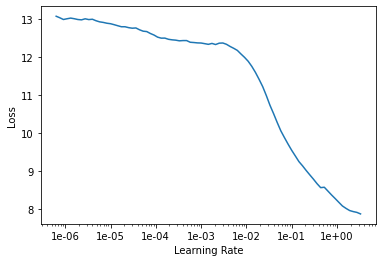

In [104]:
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.025300,0.024958,0.148058,03:26
1,0.020407,0.017833,0.139102,03:34
2,0.015653,0.016903,0.122468,03:30
3,0.012681,0.014118,0.112816,03:31
4,0.011411,0.012795,0.108371,03:28


In [106]:
learn.save('1')

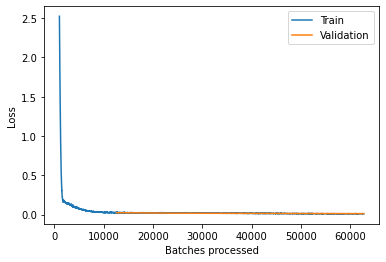

In [107]:
learn.recorder.plot_losses(skip_start=1000)

In [108]:
learn.load('1')

Learner(data=TabularDataBunch;

Train: LabelList (802943 items)
x: TabularList
Store 1115; DayOfWeek 5; Year 2015; Month 6; Day 19; StateHoliday False; CompetitionMonthsOpen 0; Promo2Weeks 25; StoreType d; Assortment c; PromoInterval Mar,Jun,Sept,Dec; CompetitionOpenSinceYear 1900; Promo2SinceYear 2012; State HE; Week 25; Events Rain; Promo_fw 1.0; Promo_bw 5.0; StateHoliday_fw 0.0; StateHoliday_bw 0.0; SchoolHoliday_fw 0.0; SchoolHoliday_bw 0.0; CompetitionDistance_na False; CloudCover_na False; CompetitionDistance -0.0130; Max_TemperatureC 0.1333; Mean_TemperatureC 0.4683; Min_TemperatureC 0.8602; Max_Humidity 0.0780; Mean_Humidity -0.3412; Min_Humidity -0.0811; Max_Wind_SpeedKm_h -0.1780; Mean_Wind_SpeedKm_h 0.1902; CloudCover 0.2552; trend 0.4066; trend_DE 0.5969; AfterStateHoliday -0.7329; BeforeStateHoliday 1.1848; Promo 1.1119; SchoolHoliday -0.4796; ,Store 1; DayOfWeek 4; Year 2015; Month 6; Day 18; StateHoliday False; CompetitionMonthsOpen 24; Promo2Weeks 0; StoreType c; Assor

In [109]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011420,0.014248,0.112319,03:29
1,0.011905,0.014875,0.114264,03:30
2,0.011190,0.013212,0.114253,03:32
3,0.009604,0.024372,0.112637,03:34
4,0.008864,0.015484,0.112512,03:33


In [110]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011729,0.017824,0.114275,03:31
1,0.012875,0.023850,0.121402,03:30
2,0.010364,0.014456,0.115965,03:32
3,0.009809,0.015876,0.115302,03:33
4,0.009047,0.023928,0.127795,03:37


# submit

In [111]:
test_preds = learn.get_preds(DatasetType.Test)
test_df["Sales"] = np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id", "Sales"]] = test_df[["Id", "Sales"]].astype("int")
test_df[["Id", "Sales"]].to_csv("rossmann_submission.csv", index=False)